In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
import sys, os
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

sys.path.append('../models/')
os.chdir('../models/')

from dataset import CaptchaDataset

%matplotlib inline

In [10]:
def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

## Load dataset

In [5]:
data = np.load('../models/.chars.npz')

In [6]:
X, y = data['X'], data['y']

In [7]:
X.shape

(50000, 40, 40, 1)

In [8]:
y.shape

(50000, 19)

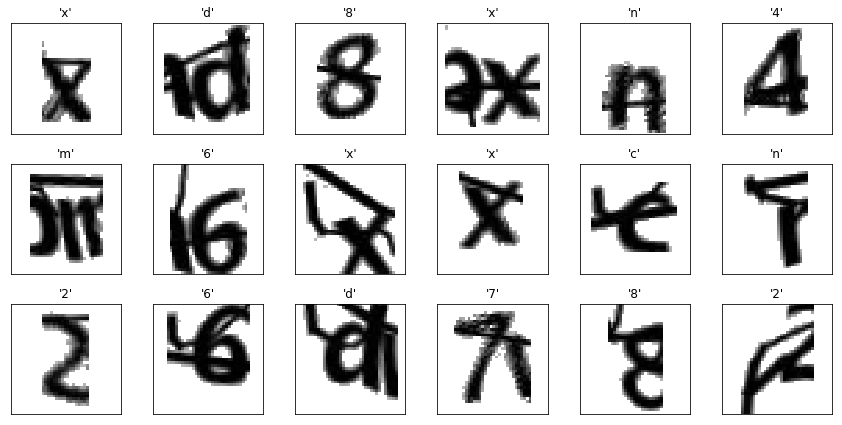

In [35]:
indexes = np.random.choice(np.arange(0, X.shape[0]), size=18)
X_batch, y_batch = X[indexes], y[indexes]

fig, ax = plt.subplots(3, 6, figsize=(12, 6))
for i, j in product(range(0, 3), range(0, 6)):
    index = i * 6 + j
    plt.sca(ax[i,j])
    show_image(X_batch[index, :, :, 0])
    title = CaptchaDataset().labels_to_text(y_batch[index].argmax().reshape([1, -1]))[0].item().decode()
    plt.title('\'{}\''.format(title))
plt.tight_layout()

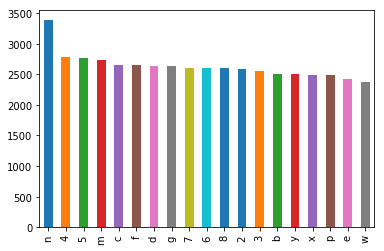

In [58]:
df = pd.DataFrame.from_dict({
    'label': [label.decode() for label in CaptchaDataset().labels_to_text(y.argmax(axis=1))]
})
df['label'].value_counts().plot.bar()

## Split dataset into train & test splits

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.15, stratify=y.argmax(axis=1))

In [60]:
X_train.shape, y_train.shape

((42500, 40, 40, 1), (42500, 19))

In [61]:
X_test.shape, y_test.shape

((7500, 40, 40, 1), (7500, 19))

## Build the model

In [76]:
num_classes = CaptchaDataset().num_char_classes

In [90]:
t_in = Input(shape=(X.shape[1:]))

x = t_in

x = Conv2D(32, kernel_size=(5, 5), kernel_initializer='he_normal', padding='same')(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPool2D((2, 2))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

t_out = x
model = Model([t_in], [t_out])


In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 40, 40, 32)        832       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 10, 10, 32)        18464     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 5, 5, 32)          0         
__________

In [92]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
initial_weights = model.get_weights()

## Train the model

In [95]:
model.set_weights(initial_weights)

In [97]:

model.fit(X_train, y_train, epochs=4, verbose=True, batch_size=8, validation_split=0.1)

Train on 38250 samples, validate on 4250 samples
Epoch 1/4
38250/38250 [==============================] - 311s 8ms/step - loss: 0.4084 - acc: 0.8889 - val_loss: 0.3585 - val_acc: 0.9019
Epoch 2/4
38250/38250 [==============================] - 317s 8ms/step - loss: 0.3548 - acc: 0.9059 - val_loss: 0.3628 - val_acc: 0.9005
Epoch 3/4
38250/38250 [==============================] - 328s 9ms/step - loss: 0.3272 - acc: 0.9129 - val_loss: 0.3822 - val_acc: 0.9071
Epoch 4/4
38250/38250 [==============================] - 319s 8ms/step - loss: 0.3563 - acc: 0.9112 - val_loss: 0.4862 - val_acc: 0.8892


## Evaluate the model

In [114]:
y_train_pred = model.predict(X_train)

In [101]:
y_test_pred = model.predict(X_test)

In [115]:
y_test_labels_pred = y_test_pred.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)
y_train_labels_pred = y_train_pred.argmax(axis=1)
y_train_labels = y_train.argmax(axis=1)

In [119]:
print('Accuracy on train set: {}\nAccuracy on test set: {}'.format(
    np.round(accuracy_score(y_train_labels, y_train_labels_pred), 3),
    np.round(accuracy_score(y_test_labels, y_test_labels_pred), 3)))

Accuracy on train set: 0.902
Accuracy on test set: 0.898


In [117]:
print(classification_report(y_train_labels, y_train_labels_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2195
           1       0.96      0.83      0.89      2167
           2       0.98      0.86      0.92      2365
           3       0.84      0.95      0.89      2355
           4       0.98      0.92      0.95      2213
           5       0.96      0.93      0.94      2220
           6       0.98      0.95      0.97      2209
           7       0.88      0.93      0.90      2131
           8       0.70      0.97      0.81      2256
           9       0.91      0.84      0.87      2241
          10       0.90      0.93      0.92      2064
          11       0.96      0.95      0.96      2256
          12       0.93      0.85      0.89      2236
          13       0.84      0.79      0.82      2329
          14       0.78      0.87      0.83      2880
          15       0.97      0.77      0.86      2120
          16       0.93      0.96      0.95      2014
          17       0.94    

In [116]:
print(classification_report(y_test_labels, y_test_labels_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       387
           1       0.96      0.83      0.89       383
           2       0.99      0.86      0.92       417
           3       0.84      0.96      0.89       415
           4       0.98      0.93      0.95       391
           5       0.96      0.92      0.94       392
           6       0.98      0.95      0.96       390
           7       0.86      0.91      0.88       376
           8       0.72      0.97      0.82       398
           9       0.90      0.86      0.88       396
          10       0.89      0.94      0.91       364
          11       0.94      0.94      0.94       398
          12       0.94      0.84      0.89       395
          13       0.83      0.80      0.82       411
          14       0.78      0.83      0.80       508
          15       0.98      0.78      0.87       374
          16       0.92      0.94      0.93       355
          17       0.93    

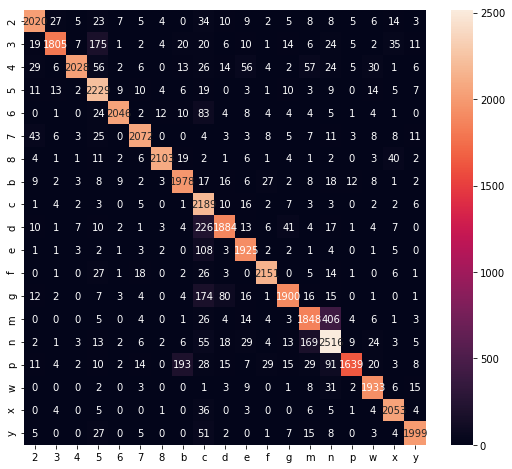

In [127]:
plt.figure(figsize=(9,8))
labels = CaptchaDataset().alphabet
sns.heatmap(confusion_matrix(y_train_labels, y_train_labels_pred), annot=True, fmt='d',
           xticklabels=labels, yticklabels=labels)